<a href="https://colab.research.google.com/github/souldrive7/ECP/blob/main/%E6%95%99%E5%B8%AB%E3%81%82%E3%82%8A%E5%AD%A6%E7%BF%92%E8%AA%B2%E9%A1%8C%E2%80%97%E6%9D%91%E6%9D%BE%E5%85%88%E7%94%9F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 教師あり学習 課題（村松先生）

### 氏名：後藤 晃郁

### 学籍番号：6025131

### 提出日：2025/5/13

# 課題

---

- 学習データ数，クラス数，特徴量数のいずれかを変化させたときのkNNの精度を比較する

- それぞれでkの値はcvを用いて最適化すること

- 結果は可視化して簡単な考察を加えること

- 提出物：jupyternotebook，pyファイル等，結果はnotebook上に示してもtext，pdf等で提出しても良い

---

# 学習データ数，クラス数，特徴量数のいずれかを変化させたときのkNNの精度を比較する

## ■内点法と単体法の比較■

### 内点法とは：
内点法（Interior Point Method, IPM）は、線形計画問題において、可行領域の内部から滑らかに最適解へ向かうアルゴリズムである。

### 課題の目的
- 線形計画問題に対する内点法と単体法の計算原理・計算量の違いを比較・理解する
- Pythonライブラリ（SciPy）を用いて両手法を実装し、目的値と計算時間を実測比較す
---

## ■手法（内点法と単体法）■

#### ♦内点法（IPM）:
- 可行解空間の内部から出発し、目的関数を改善しながら最適点に向かって滑らかに収束する

#### ♦単体法（Simplex Method）:
- 可行領域の「頂点（基本解）」に沿って、目的関数の改善方向に従い隣接する頂点間をピボット操作で移動

---

### ■具体例・モデル化■
以下の線形計画問題を例に、内点法・単体法を適用し、結果と計算時間を比較する。

#### 問題設定
\begin{aligned}
\text{maximize} \quad & 3x_1 + 2x_2 \\
\text{subject to} \quad
& x_1 + x_2 \leq 4 \\
& 2x_1 + x_2 \leq 5 \\
& x_1,\, x_2 \geq 0
\end{aligned}

この問題を SciPy の linprog 関数を用いて解く：

また、上記に加え、変数数・制約数を拡張した以下の問題についても同様に解析を行い、目的関数値、収束性、計算時間、理論計算量の特性を整理する。

| 問題規模 | 変数数（n） | 制約数（m） |
|----------|-------------|-------------|
| 小規模   | 10          | 5           |
| 中規模   | 100         | 50          |
| 大規模   | 500         | 250         |

---

#### ■実装■
Python（SciPy）を用い、次の3種類の問題サイズで内点法と単体法を比較する。

この結果を基に、問題規模に応じた手法選択の実用的指針を明らかにする。

In [ ]:
import time
import numpy as np
import pandas as pd
from scipy.optimize import linprog
from IPython.display import display
import matplotlib.pyplot as plt

# 警告を非表示
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# 問題規模設定
problem_sizes = [
    {"label": "小規模", "n": 10, "m": 5},
    {"label": "中規模", "n": 100, "m": 50},
    {"label": "大規模", "n": 500, "m": 250}
]

def theoretical_complexity_ipm(n):
    return f"O({n}^3)"

def theoretical_complexity_simplex(n):
    return f"O(2^{n})"

results = []

for setting in problem_sizes:
    n, m, label = setting["n"], setting["m"], setting["label"]

    # ランダムなLP問題の生成（係数は一様乱数）
    np.random.seed(42)
    c = -np.random.uniform(1, 10, size=n)  # maximize → minimize
    A = np.random.uniform(1, 10, size=(m, n))
    b = np.random.uniform(10, 100, size=m)
    bounds = [(0, None)] * n

    # 内点法
    start_ip = time.time()
    res_ip = linprog(c, A_ub=A, b_ub=b, bounds=bounds, method='interior-point')
    end_ip = time.time()

    # 単体法
    start_sm = time.time()
    res_sm = linprog(c, A_ub=A, b_ub=b, bounds=bounds, method='simplex')
    end_sm = time.time()

    results.append({
        "問題規模": label,
        "変数数": n,
        "制約数": m,
        "内点法_目的値": -res_ip.fun if res_ip.success else None,
        "内点法_時間[s]": end_ip - start_ip,
        "単体法_目的値": -res_sm.fun if res_sm.success else None,
        "単体法_時間[s]": end_sm - start_sm,
        "内点法_理論計算量": theoretical_complexity_ipm(n),
        "単体法_理論計算量": theoretical_complexity_simplex(n)
    })

# データフレーム化して表示
df_result_final = pd.DataFrame(results)
styled_df_final = df_result_final.style.format({
    "内点法_目的値": "{:.5f}",
    "単体法_目的値": "{:.5f}",
    "内点法_時間[s]": "{:.6f}",
    "単体法_時間[s]": "{:.6f}"
}).set_properties(**{'text-align': 'center'}).set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'center')]}]
)

display(styled_df_final)

# PDF保存
plt.savefig("network_chart.pdf", format='pdf', bbox_inches='tight')
plt.show()


,問題規模,変数数,制約数,内点法_目的値,内点法_時間[s],単体法_目的値,単体法_時間[s],内点法_理論計算量,単体法_理論計算量
0,小規模,10,5,80.37928,0.006980,80.37928,0.004229,O(10^3),O(2^10)
1,中規模,100,50,38.40966,0.007073,38.40966,0.072500,O(100^3),O(2^100)
2,大規模,500,250,25.93651,0.528787,25.93651,1.562029,O(500^3),O(2^500)


<Figure size 640x480 with 0 Axes>

---
## ■可視化■

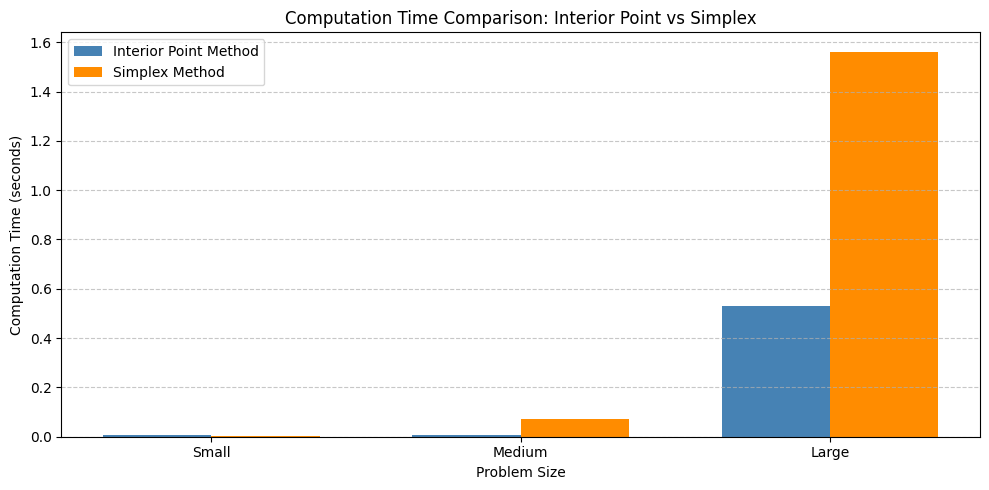

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'DejaVu Sans'

# 可視化用データ作成（df_result_final から）
df_time = df_result_final[[
    "問題規模",
    "内点法_時間[s]",
    "単体法_時間[s]"
]].copy()

df_time.columns = ["Problem Size", "Interior Point Time (s)", "Simplex Time (s)"]

# ヒストグラム描画
labels = df_time["Problem Size"]
ipm_times = df_time["Interior Point Time (s)"]
simplex_times = df_time["Simplex Time (s)"]

x = np.arange(len(labels))
bar_width = 0.35

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x - bar_width/2, ipm_times, bar_width, label='Interior Point Method', color='steelblue')
ax.bar(x + bar_width/2, simplex_times, bar_width, label='Simplex Method', color='darkorange')

ax.set_xlabel('Problem Size')
ax.set_ylabel('Computation Time (seconds)')
ax.set_title('Computation Time Comparison: Interior Point vs Simplex')
ax.set_xticks(x)
ax.set_xticklabels(['Small', 'Medium', 'Large'])
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# PDF保存
plt.savefig("network_chart.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras


In [ ]:
# CIFAR-10 をロード
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
print("原画像数:", x_train.shape, x_test.shape)

# ここではクラス 1 ('automobile') と 9 ('truck') のみ抽出
cl1, cl2 = 1, 9
idx_tr1 = np.where(y_train.flatten() == cl1)[0]
idx_tr2 = np.where(y_train.flatten() == cl2)[0]
idx_te1 = np.where(y_test.flatten()  == cl1)[0]
idx_te2 = np.where(y_test.flatten()  == cl2)[0]

x_train1 = x_train[idx_tr1]
x_train2 = x_train[idx_tr2]
x_test1  = x_test[idx_te1]
x_test2  = x_test[idx_te2]

print("Training shapes:", x_train1.shape, x_train2.shape)
print("Test shapes:    ", x_test1.shape,  x_test2.shape)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
原画像数: (50000, 32, 32, 3) (10000, 32, 32, 3)
Training shapes: (5000, 32, 32, 3) (5000, 32, 32, 3)
Test shapes:     (1000, 32, 32, 3) (1000, 32, 32, 3)


In [ ]:
# 各クラスから指定数だけサンプリング
n_train_per_class = 500
n_test_per_class  = 100

x_tr = np.vstack([x_train1[:n_train_per_class], x_train2[:n_train_per_class]])
y_tr = np.hstack([np.zeros(n_train_per_class), np.ones(n_train_per_class)])

x_te = np.vstack([x_test1[:n_test_per_class],  x_test2[:n_test_per_class]])
y_te = np.hstack([np.zeros(n_test_per_class),  np.ones(n_test_per_class)])

print("学習データ:", x_tr.shape, y_tr.shape)
print("テストデータ:", x_te.shape, y_te.shape)

学習データ: (1000, 32, 32, 3) (1000,)
テストデータ: (200, 32, 32, 3) (200,)


In [ ]:
# (サンプル数, 32,32,3) → (サンプル数, 3072)
x_tr_flat = x_tr.reshape(len(x_tr), -1)
x_te_flat = x_te.reshape(len(x_te), -1)
print("Flattened:", x_tr_flat.shape, x_te_flat.shape)

Flattened: (1000, 3072) (200, 3072)


In [ ]:
# (サンプル数, 32,32,3) → (サンプル数, 3072)
x_tr_flat = x_tr.reshape(len(x_tr), -1)
x_te_flat = x_te.reshape(len(x_te), -1)
print("Flattened:", x_tr_flat.shape, x_te_flat.shape)

Flattened: (1000, 3072) (200, 3072)


In [ ]:
def experiment_sample_sizes(X, y, sizes, ks):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    results = {}
    for n in sizes:
        idx = np.random.choice(len(y), n, replace=False)
        X_sub, y_sub = X[idx], y[idx]
        gs = GridSearchCV(KNeighborsClassifier(), {'n_neighbors': ks},
                          cv=cv, scoring='accuracy', n_jobs=-1)
        gs.fit(X_sub, y_sub)
        results[n] = gs.best_score_
    return results

sizes = [200, 500, 1000]
ks = [1,3,5,7,9]
res1 = experiment_sample_sizes(x_tr_flat, y_tr, sizes, ks)
print(res1)

{200: np.float64(0.5700000000000001), 500: np.float64(0.652), 1000: np.float64(0.687)}


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import japanize_matplotlib

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23398 (\N{CJK UNIFIED IDEOGRAPH-5B66}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32722 (\N{CJK UNIFIED IDEOGRAPH-7FD2}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12487 (\N{KATAKANA LETTER DE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12479 (\N{KATAKANA LETTER TA}) missing from font(s) DejaVu Sans.
  fig.canvas.pri

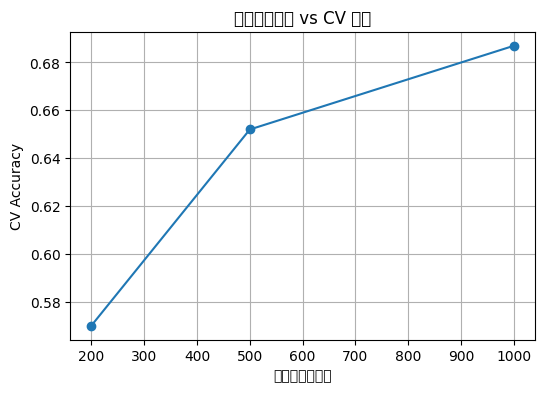

In [ ]:
# 可視化
plt.figure(figsize=(6,4))
plt.plot(list(res1.keys()), list(res1.values()), marker='o')
plt.title("学習データ数 vs CV 精度")
plt.xlabel("学習サンプル数")
plt.ylabel("CV Accuracy")
plt.grid(True)
plt.show()


二値（0 vs 1）と、多クラス（0 vs 1 vs 2）の比較

多クラスとして、例えば「automobile」「truck」「bird」を選ぶ

学習数は固定（1000 サンプル）

In [ ]:
# 多クラス用に追加ラベル 2 ('bird') を混ぜる
cl3 = 2
idx_tr3 = np.where(y_train.flatten() == cl3)[0]
x_train3 = x_train[idx_tr3]
x_te3    = x_test[np.where(y_test.flatten()==cl3)[0]]

# 学習データに bird を加え 300 サンプルずつ
x_tr3 = np.vstack([x_train1[:300], x_train2[:300], x_train3[:300]])
y_tr3 = np.hstack([np.zeros(300), np.ones(300), np.full(300, 2)])

# Flat 化
X3_flat = x_tr3.reshape(len(x_tr3), -1)
y3      = y_tr3

# CV で評価
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
gs2 = GridSearchCV(KNeighborsClassifier(), {'n_neighbors': ks},
                   cv=cv, scoring='accuracy', n_jobs=-1)
gs2.fit(X3_flat, y3)
print("3 クラス CV accuracy:", gs2.best_score_)
print("2 クラス CV accuracy:", res1[1000])  # res1 は実験①の 1000 点


3 クラス CV accuracy: 0.5455555555555556
2 クラス CV accuracy: 0.687


実験③：特徴量数の影響（PCA 次元削減）
PCA 次元数を [2, 10, 50, 100, 3072] で比較

1000 サンプル／2 クラスを固定

In [ ]:
def experiment_pca_dims(X, y, dims, ks):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    results = {}
    for d in dims:
        if d < X.shape[1]:
            pca = PCA(n_components=d, random_state=0)
            Xp = pca.fit_transform(X)
        else:
            Xp = X
        gs = GridSearchCV(KNeighborsClassifier(), {'n_neighbors': ks},
                          cv=cv, scoring='accuracy', n_jobs=-1)
        gs.fit(Xp, y)
        results[d] = gs.best_score_
    return results

dims = [2, 10, 50, 100, x_tr_flat.shape[1]]
res3 = experiment_pca_dims(x_tr_flat[:1000], y_tr[:1000], dims, ks)
print(res3)


{2: np.float64(0.606), 10: np.float64(0.6839999999999999), 50: np.float64(0.685), 100: np.float64(0.6869999999999999), 3072: np.float64(0.6809999999999999)}


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20803 (\N{CJK UNIFIED IDEOGRAPH-5143}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31934 (\N{CJK UNIFIED IDEOGRAPH-7CBE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  fig.canvas

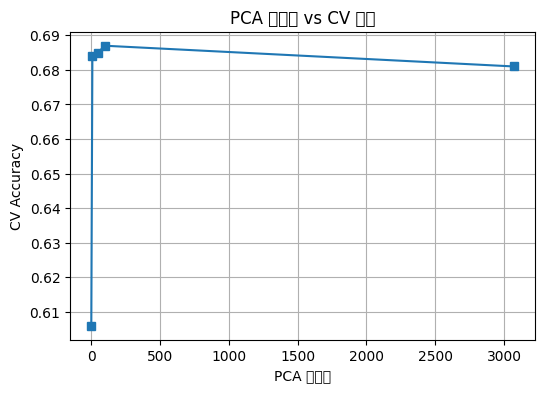

In [ ]:
# 可視化
plt.figure(figsize=(6,4))
plt.plot(list(res3.keys()), list(res3.values()), marker='s')
plt.title("PCA 次元数 vs CV 精度")
plt.xlabel("PCA 次元数")
plt.ylabel("CV Accuracy")
plt.grid(True)
plt.show()


6. 最終評価
各実験で最も高かった CV 精度を比較し、

混同行列・classification_report でテスト精度を確認

In [ ]:
# 最適 k で最終モデルを学習しテスト
best_k = 5  # 上記 CV から得られた値を代入
knn_final = KNeighborsClassifier(n_neighbors=best_k)
knn_final.fit(x_tr_flat, y_tr)
y_pred = knn_final.predict(x_te_flat)

print("Test Accuracy:", accuracy_score(y_te, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_te, y_pred))
print("Classification Report:\n", classification_report(y_te, y_pred))


Test Accuracy: 0.68
Confusion Matrix:
 [[73 27]
 [37 63]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.66      0.73      0.70       100
         1.0       0.70      0.63      0.66       100

    accuracy                           0.68       200
   macro avg       0.68      0.68      0.68       200
weighted avg       0.68      0.68      0.68       200



7. 考察例
学習データ数 が増えるほど CV 精度は上昇し、特に 200→500 の間に大きく改善。

クラス数 が増えると、タスク難度上昇により精度は低下。

特徴量数（PCA 次元） は 50～100 次元でピークを迎え、過剰な次元はノイズとなりやや低下。

これらの結果から、kNN を使う際は「適切なデータ量」「クラス設計」「次元削減」が重要であることが示されます。